<a href="https://colab.research.google.com/github/AbirZaman1762862/Deep-Learning-/blob/main/Crowd_Counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
import scipy.io
import os
import tensorflow_probability as tfp
import albumentations as A
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,Lambda,
                                     RandomContrast, Rescaling, Resizing, Reshape,LeakyReLU)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l1_l2

# Download Data

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d tthien/shanghaitech-with-people-density-map

100% 4.79G/4.79G [03:34<00:00, 21.7MB/s]
100% 4.79G/4.79G [03:34<00:00, 24.0MB/s]


In [ ]:
!unzip "/content/shanghaitech-with-people-density-map.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_199.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_2.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_20.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_200.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_201.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_202.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_203.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_204.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_205.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_206.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_207.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/i

# DATA PREPARATION

In [ ]:
train_images = "/content/dataset/ShanghaiTech/part_B/train_data/images/"
train_heads = "/content/dataset/ShanghaiTech/part_B/train_data/ground-truth/"
val_images = "/content/dataset/ShanghaiTech/part_B/test_data/images/"
val_heads = "/content/dataset/ShanghaiTech/part_B/test_data/ground-truth/"
IN_X,IN_Y=768,1024
OUT_X,OUT_Y=96,128
LR=1e-6
BATCH_SIZE=4
EPOCH=1
SUBSAMPLING_FACTOR=IN_X//OUT_X
MEAN = tf.constant([0.485, 0.456, 0.406])
STD = tf.constant([0.229, 0.224, 0.225])

In [ ]:
train_image_list = [train_images+i for i in os.listdir(train_images)]
train_head_list = [train_heads+"GT_"+i[:-3]+"mat" for i in os.listdir(train_images)]

val_image_list = [val_images+i for i in os.listdir(val_images)]
val_head_list = [val_heads+"GT_"+i[:-3]+"mat" for i in os.listdir(val_images)]


In [ ]:
print(train_image_list)
print(train_head_list)

['/content/dataset/ShanghaiTech/part_B/train_data/images/IMG_169.jpg', '/content/dataset/ShanghaiTech/part_B/train_data/images/IMG_102.jpg', '/content/dataset/ShanghaiTech/part_B/train_data/images/IMG_183.jpg', '/content/dataset/ShanghaiTech/part_B/train_data/images/IMG_346.jpg', '/content/dataset/ShanghaiTech/part_B/train_data/images/IMG_36.jpg', '/content/dataset/ShanghaiTech/part_B/train_data/images/IMG_109.jpg', '/content/dataset/ShanghaiTech/part_B/train_data/images/IMG_145.jpg', '/content/dataset/ShanghaiTech/part_B/train_data/images/IMG_53.jpg', '/content/dataset/ShanghaiTech/part_B/train_data/images/IMG_65.jpg', '/content/dataset/ShanghaiTech/part_B/train_data/images/IMG_182.jpg', '/content/dataset/ShanghaiTech/part_B/train_data/images/IMG_278.jpg', '/content/dataset/ShanghaiTech/part_B/train_data/images/IMG_306.jpg', '/content/dataset/ShanghaiTech/part_B/train_data/images/IMG_281.jpg', '/content/dataset/ShanghaiTech/part_B/train_data/images/IMG_10.jpg', '/content/dataset/Shang

In [ ]:
train_dataset=tf.data.Dataset.from_tensor_slices((train_image_list, train_head_list))
val_dataset=tf.data.Dataset.from_tensor_slices((val_image_list, val_head_list))

In [ ]:
for i,j in train_dataset.take(1):
  print(i,j)

tf.Tensor(b'/content/dataset/ShanghaiTech/part_B/train_data/images/IMG_169.jpg', shape=(), dtype=string) tf.Tensor(b'/content/dataset/ShanghaiTech/part_B/train_data/ground-truth/GT_IMG_169.mat', shape=(), dtype=string)


In [ ]:
def gauss_dist(x,u=0,sigma=10):
  return (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-0.5*((x-u)/sigma)**2)

In [ ]:
def get_density_map(path):
  mat = scipy.io.loadmat(path)
  points = mat["image_info"][0][0][0][0][0]/SUBSAMPLING_FACTOR
  num_heads = len(points)
  density_map = np.zeros((OUT_X*2,OUT_Y*2))
  h,w = OUT_X,OUT_Y
  gauss_radius = 10
  shift = 50
  for i,point in enumerate(points):
    point = point.astype(int)
    a = np.linspace(-gauss_radius,gauss_radius,gauss_radius*2)
    gauss_one_d = gauss_dist(a,0,5)
    gauss_two_d = np.outer(gauss_one_d,gauss_one_d)
    gauss_two_d_norm = gauss_two_d/np.sum(gauss_two_d)

    density_map[
        point[1]-gauss_radius+shift:point[1]+gauss_radius+shift,
        point[0]-gauss_radius+shift:point[0]+gauss_radius+shift,
    ]+=gauss_two_d_norm
  out = density_map[shift:shift+h,shift:shift+w]
  factor = len(points)/np.sum(out)
  return tf.constant(out*factor, dtype=tf.float32)

In [ ]:
density_map = get_density_map("/content/dataset/ShanghaiTech/part_B/train_data/ground-truth/GT_IMG_53.mat")

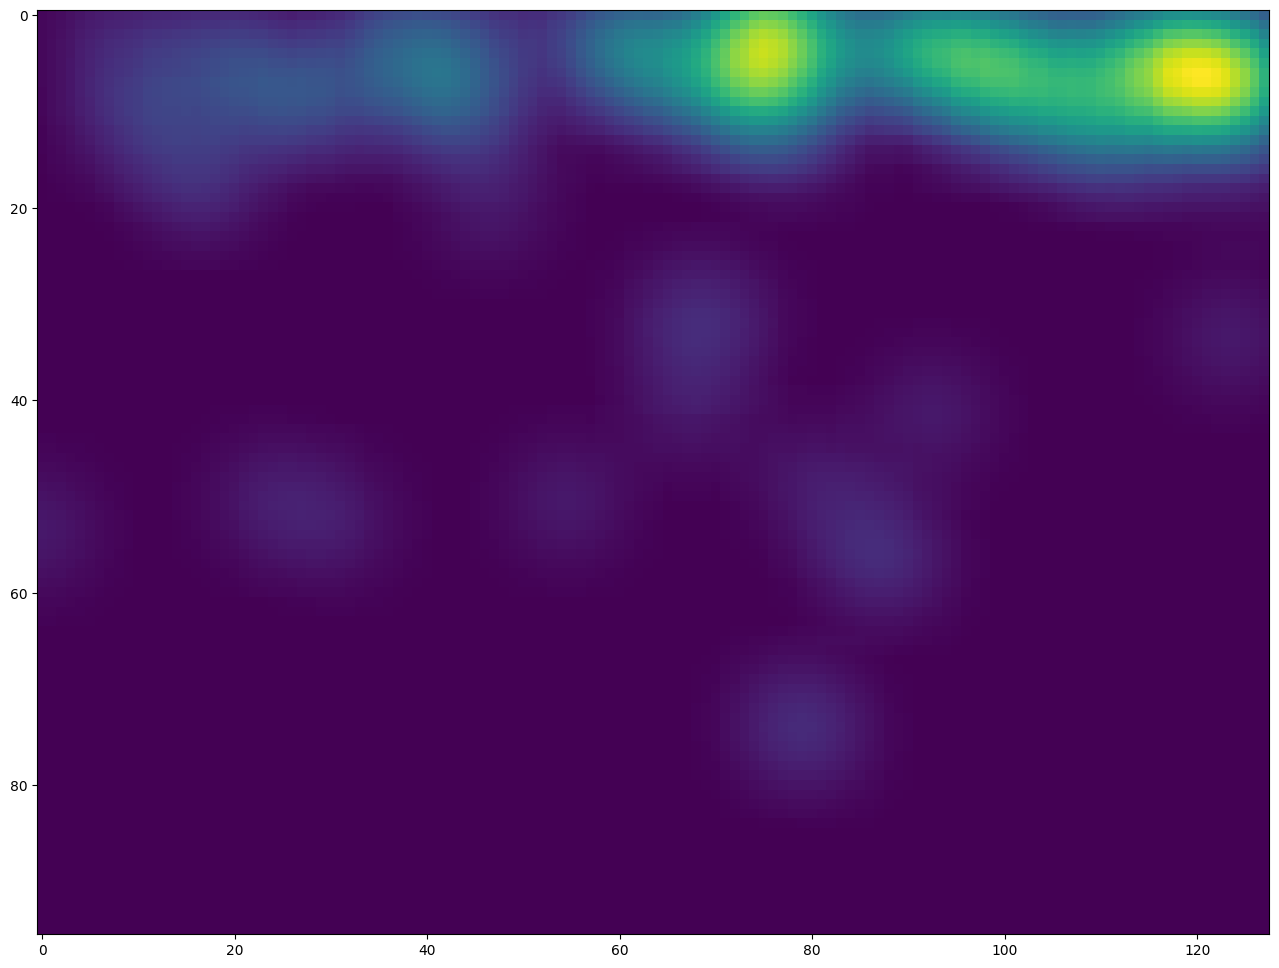

In [ ]:
plt.figure(figsize=(20,12))
plt.imshow(density_map)

In [ ]:
def get_immap(im_path,heads_path):
  img=tf.io.decode_jpeg(tf.io.read_file(im_path))
  img=tf.cast(tf.image.resize(img, [IN_X,IN_Y]),dtype=tf.float32)
  input_image = tf.image.convert_image_dtype(img, tf.float32)/255.
  input_image = (input_image - MEAN) / tf.maximum(STD, tf.keras.backend.epsilon())

  map=tf.numpy_function(func=get_density_map, inp=[heads_path], Tout=tf.float32)
  return tf.ensure_shape(input_image,[IN_X,IN_Y,3]),tf.ensure_shape(map,[OUT_X,OUT_Y])

In [ ]:
for i,j in train_dataset.take(1):
  print(i,j)

tf.Tensor(b'/content/dataset/ShanghaiTech/part_B/train_data/images/IMG_169.jpg', shape=(), dtype=string) tf.Tensor(b'/content/dataset/ShanghaiTech/part_B/train_data/ground-truth/GT_IMG_169.mat', shape=(), dtype=string)


In [ ]:
train_ds = train_dataset.map(get_immap)
val_ds = val_dataset.map(get_immap)

In [ ]:
for i,j in train_ds.take(1):
  print(i.shape,j.shape)

(768, 1024, 3) (96, 128)


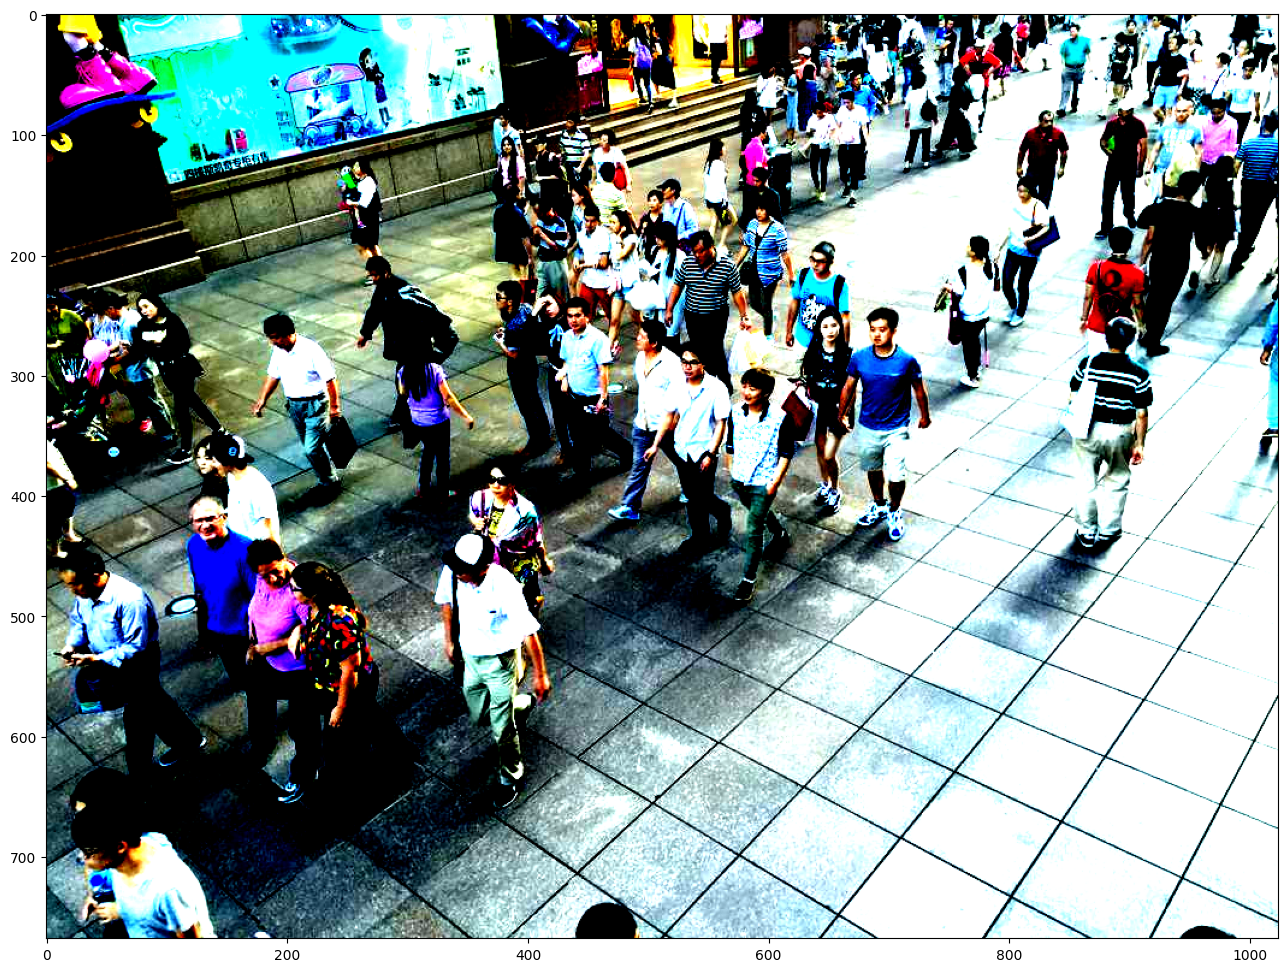

In [ ]:
plt.figure(figsize=(20,12))
plt.imshow(i)

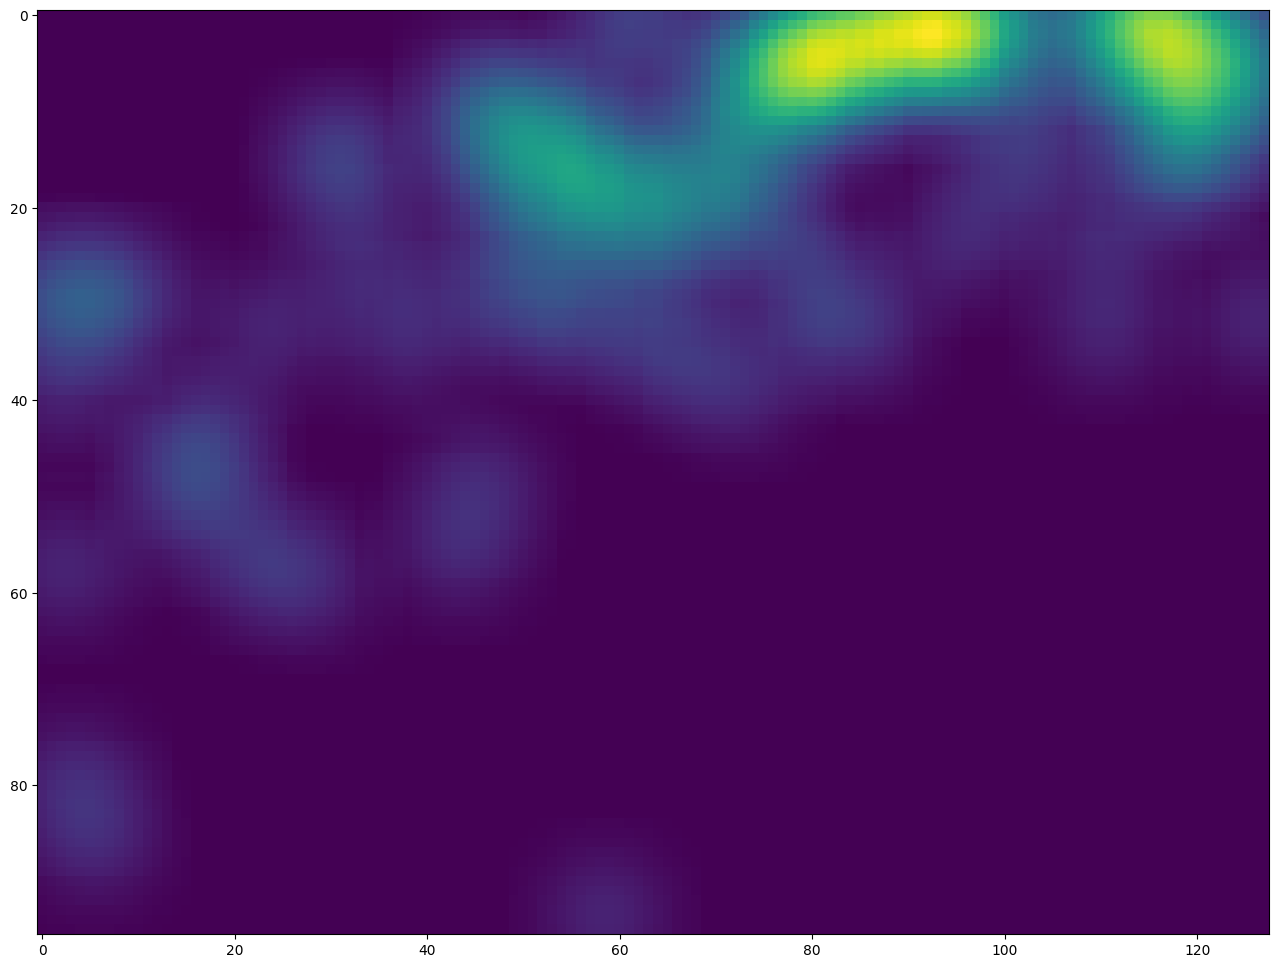

In [ ]:
plt.figure(figsize=(20,12))
plt.imshow(j)


## Data AUgmentation

In [ ]:
def tiling(random_patches):
  main_patch = []
  line_patch = []

  for i in range(1,16+1):
    if i%4==0:
      line_patch.append(random_patches[i-1])
      main_patch.append(tf.concat(line_patch,axis=1))
      line_patch = []
    else:
      line_patch.append(random_patches[i-1])
  return tf.concat(main_patch,axis=0)

In [ ]:
random_patches = [i*tf.ones([3,4]) for i in range(1,16+1)]
print(tiling(random_patches))

tf.Tensor(
[[ 1.  1.  1.  1.  2.  2.  2.  2.  3.  3.  3.  3.  4.  4.  4.  4.]
 [ 1.  1.  1.  1.  2.  2.  2.  2.  3.  3.  3.  3.  4.  4.  4.  4.]
 [ 1.  1.  1.  1.  2.  2.  2.  2.  3.  3.  3.  3.  4.  4.  4.  4.]
 [ 5.  5.  5.  5.  6.  6.  6.  6.  7.  7.  7.  7.  8.  8.  8.  8.]
 [ 5.  5.  5.  5.  6.  6.  6.  6.  7.  7.  7.  7.  8.  8.  8.  8.]
 [ 5.  5.  5.  5.  6.  6.  6.  6.  7.  7.  7.  7.  8.  8.  8.  8.]
 [ 9.  9.  9.  9. 10. 10. 10. 10. 11. 11. 11. 11. 12. 12. 12. 12.]
 [ 9.  9.  9.  9. 10. 10. 10. 10. 11. 11. 11. 11. 12. 12. 12. 12.]
 [ 9.  9.  9.  9. 10. 10. 10. 10. 11. 11. 11. 11. 12. 12. 12. 12.]
 [13. 13. 13. 13. 14. 14. 14. 14. 15. 15. 15. 15. 16. 16. 16. 16.]
 [13. 13. 13. 13. 14. 14. 14. 14. 15. 15. 15. 15. 16. 16. 16. 16.]
 [13. 13. 13. 13. 14. 14. 14. 14. 15. 15. 15. 15. 16. 16. 16. 16.]], shape=(12, 16), dtype=float32)


In [ ]:
SSF = 8

In [ ]:
def augmentation(im, map):
  if tf.random.uniform(shape=[], minval=0, maxval=1.)>0.99:
    random_im_patches = []
    random_map_patches = []
    for i in range(16):
      rand_point = [
          tf.random.uniform(shape=[], minval=0, maxval=int(0.75*IN_X), dtype=tf.int32),
          tf.random.uniform(shape=[], minval=0, maxval=int(0.75*IN_Y), dtype=tf.int32),
      ]
      random_im_patches.append(im[rand_point[0]:rand_point[0]+IN_X//4,
                                  rand_point[1]:rand_point[1]+IN_Y//4])
      random_map_patches.append(map[rand_point[0]//SSF:(rand_point[0]//SSF)+IN_X//4//SSF,
                                    rand_point[1]//SSF:(rand_point[1]//SSF)+IN_Y//4//SSF])
    tiled_image = tiling(random_im_patches)
    tiled_map = tiling(random_map_patches)
  else:
    tiled_image = im
    tiled_map = map
  return tiled_image, tiled_map

In [ ]:
train_aug_ds = train_ds.map(augmentation).batch(BATCH_SIZE)
val_aug_ds = val_ds.batch(BATCH_SIZE)


In [ ]:
for i,j in train_aug_ds.take(1):
  print(i.shape,j.shape)

(4, 768, 1024, 3) (4, 96, 128)


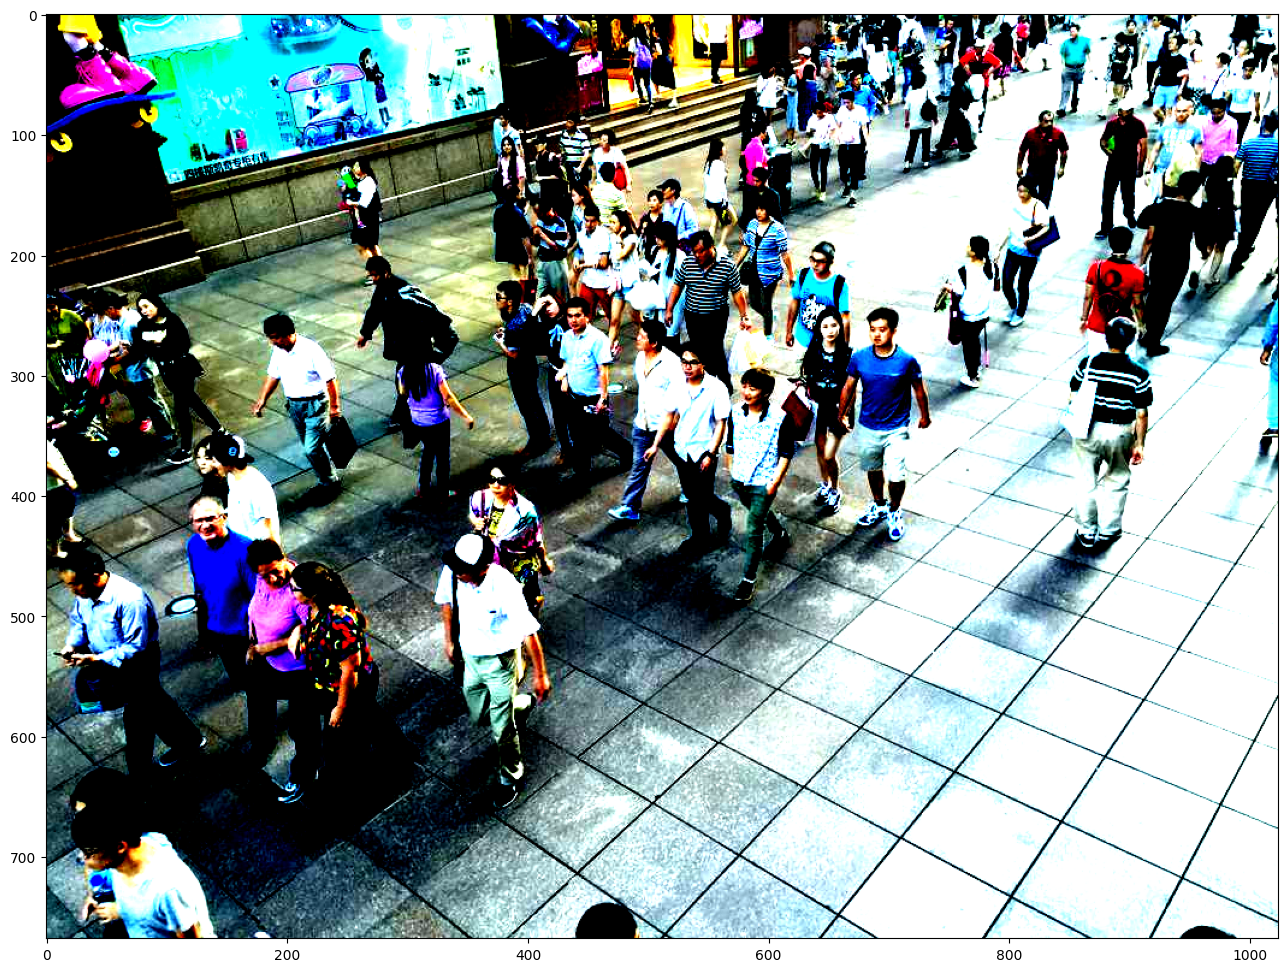

In [ ]:
plt.figure(figsize=(20,12))
plt.imshow(i[0])

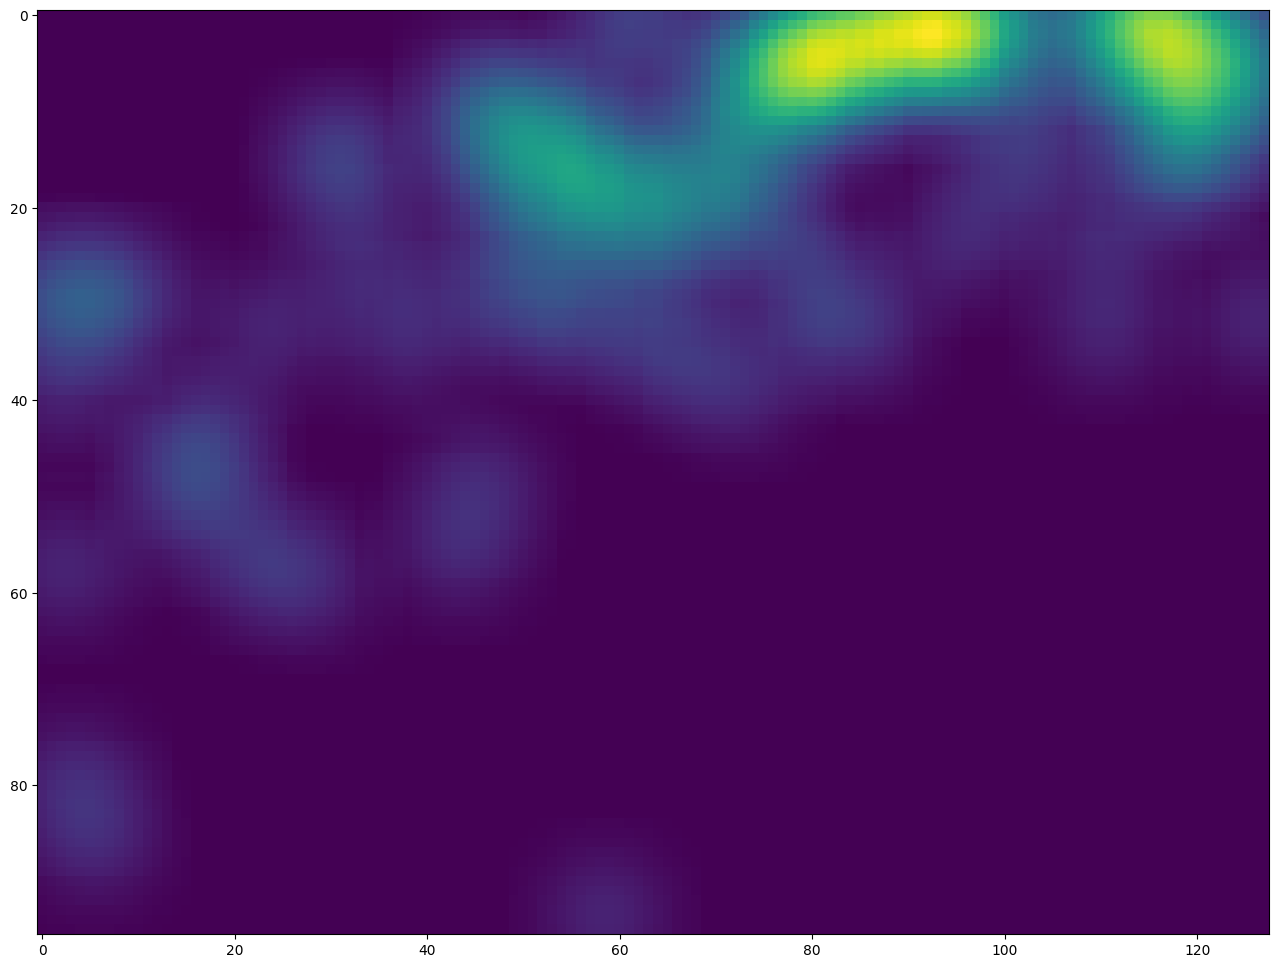

In [ ]:
plt.figure(figsize=(20,12))
plt.imshow(j[0])

# MODELING

In [ ]:
base_model = VGG16(
        weights='imagenet',
        input_shape=(IN_X,IN_Y,3),
        include_top=False,)
base_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768, 1024, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 768, 1024, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 768, 1024, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 384, 512, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 384, 512, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 384, 512, 128)     147584    
                                                              

In [ ]:
def get_base_model():
    base_model = VGG16(
        weights='imagenet',
        input_shape=(IN_X,IN_Y,3),
        include_top=False,)
    base_model.trainable=False
    block4_conv3=[base_model.get_layer(layer_name).output for layer_name in ["block4_conv3"]]

    return Model(
        inputs=[base_model.inputs],outputs=block4_conv3
    )

get_base_model().summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 768, 1024, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 768, 1024, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 768, 1024, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 384, 512, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 384, 512, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 384, 512, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 192, 256, 128)     0   

In [ ]:
inputs=tf.keras.Input(shape=(IN_X,IN_Y,3))
x=get_base_model()(inputs)
init=RandomNormal(stddev=0.01)

x=Conv2D(512, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(512, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(512, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(256, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(128, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(64, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
out=Conv2D(1, (1,1), activation = 'sigmoid', dilation_rate=1,kernel_initializer=init,padding='same')(x)

csrnet_model=tf.keras.Model(inputs=inputs,outputs=out)
csrnet_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 768, 1024, 3)]    0         
                                                                 
 model_10 (Functional)       (None, 96, 128, 512)      7635264   
                                                                 
 conv2d_21 (Conv2D)          (None, 96, 128, 512)      2359808   
                                                                 
 conv2d_22 (Conv2D)          (None, 96, 128, 512)      2359808   
                                                                 
 conv2d_23 (Conv2D)          (None, 96, 128, 512)      2359808   
                                                                 
 conv2d_24 (Conv2D)          (None, 96, 128, 256)      1179904   
                                                                 
 conv2d_25 (Conv2D)          (None, 96, 128, 128)      295

In [ ]:
def custom_loss(y_true,y_pred):
  return tf.sqrt(tf.math.reduce_sum(tf.square(y_true-y_pred)))

In [ ]:
LR=1e-4
csrnet_model.compile(
    loss = 'binary_crossentropy',
    optimizer = SGD(learning_rate = LR),
    #run_eagerly = True,
)

In [ ]:
val_aug_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 768, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 128), dtype=tf.float32, name=None))>

In [ ]:
#csrnet_model.load_weights("/content/drive/MyDrive/csrnet.h5")

In [ ]:
EPOCH=500
history = csrnet_model.fit(
    train_aug_ds,
    #validation_data=val_aug_ds,
    verbose=1,
    shuffle=True,
    epochs=EPOCH,)

Epoch 1/500
100/100 [==============================] - 25s 251ms/step - loss: 0.1113
Epoch 2/500
100/100 [==============================] - 25s 248ms/step - loss: 0.1036
Epoch 3/500
100/100 [==============================] - 25s 249ms/step - loss: 0.0976
Epoch 4/500
100/100 [==============================] - 25s 252ms/step - loss: 0.0928
Epoch 5/500
100/100 [==============================] - 25s 246ms/step - loss: 0.0890
Epoch 6/500
100/100 [==============================] - 25s 251ms/step - loss: 0.0858
Epoch 7/500
100/100 [==============================] - 25s 248ms/step - loss: 0.0837
Epoch 8/500
100/100 [==============================] - 25s 253ms/step - loss: 0.0816
Epoch 9/500
100/100 [==============================] - 25s 250ms/step - loss: 0.0803
Epoch 10/500
100/100 [==============================] - 25s 247ms/step - loss: 0.0790
Epoch 11/500
100/100 [==============================] - 24s 244ms/step - loss: 0.0778
Epoch 12/500
100/100 [==============================] - 24s 242

In [ ]:
#model.save_weights('/content/drive/MyDrive/csrnet.h5')

# TESTING

In [ ]:
def get_image(im_path):
  img=tf.io.decode_jpeg(tf.io.read_file(im_path))
  img=tf.cast(tf.image.resize(img, [IN_X,IN_Y]),dtype=tf.float32)
  input_image = tf.image.convert_image_dtype(img, tf.float32)/255.
  input_image = (input_image - MEAN) / tf.maximum(STD, tf.keras.backend.epsilon())
  input_image = np.array(input_image)
  return input_image

1/1 [==============================] - 0s 39ms/step
The actual number of people is= 181
The predicted number of people is = 150.25526


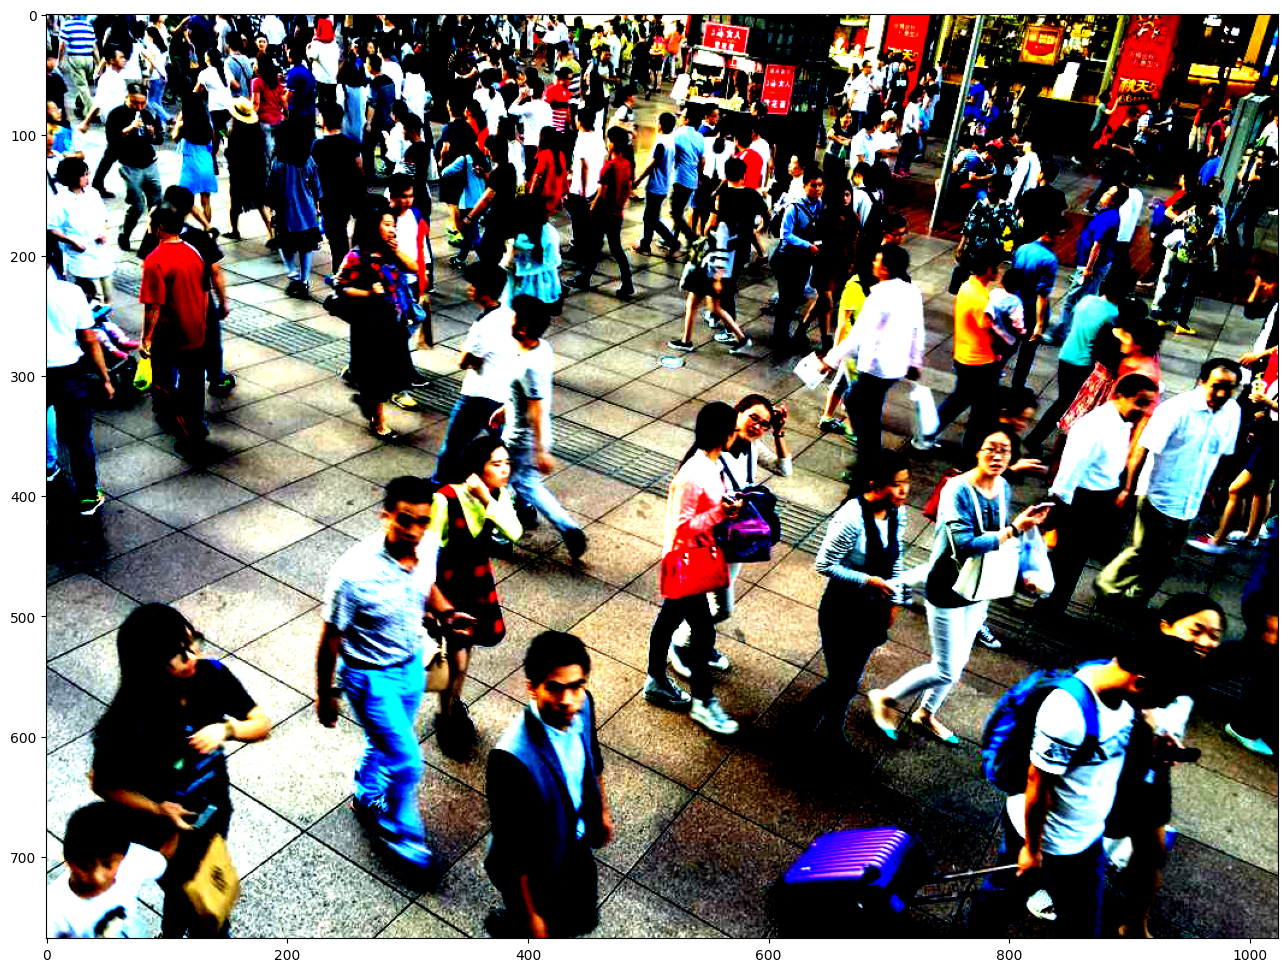

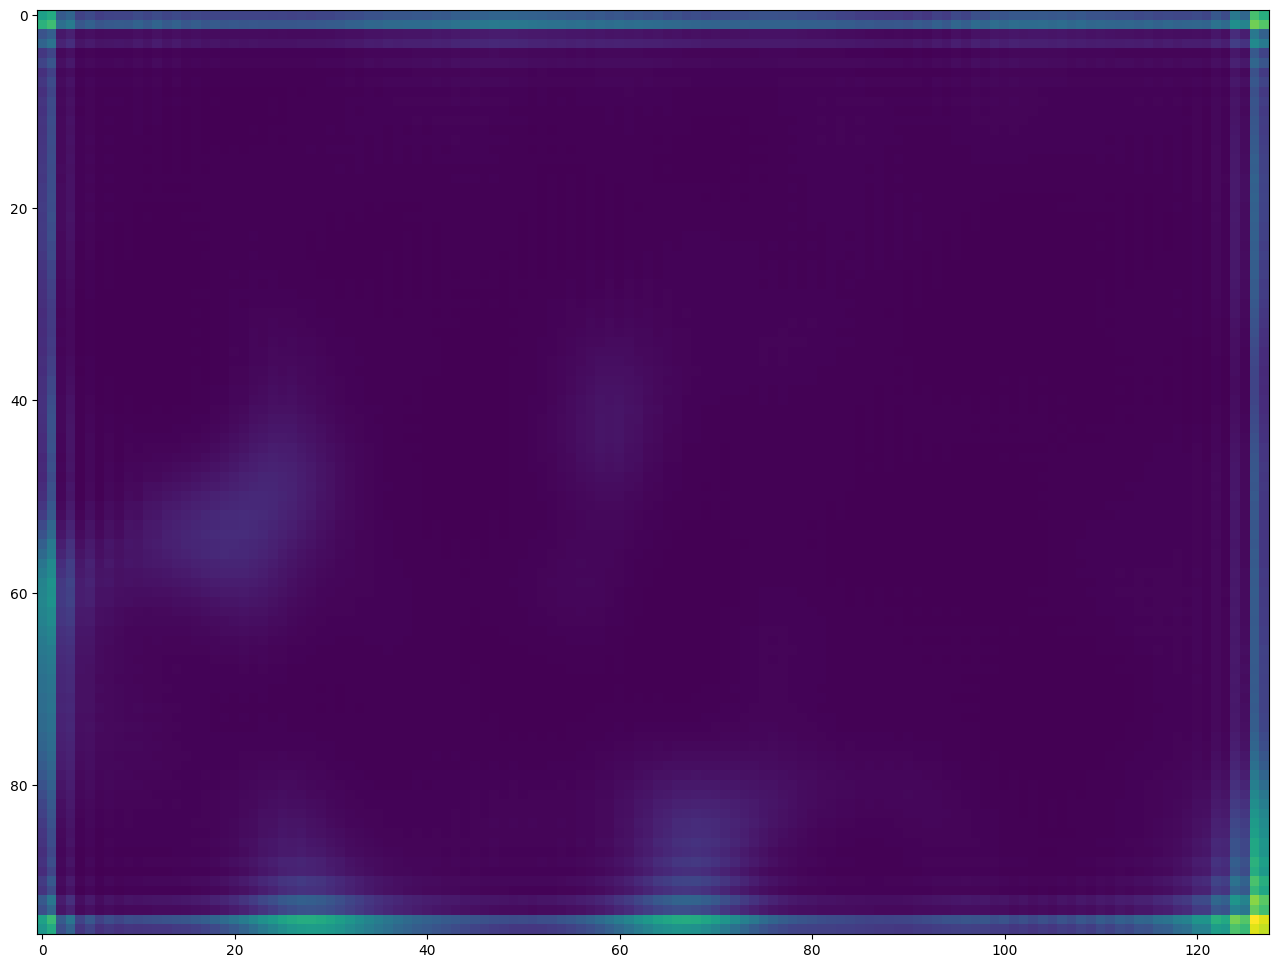

In [ ]:
NUM = 11
test_path = "/content/dataset/ShanghaiTech/part_B/test_data/images/IMG_"+str(NUM)+".jpg"
map_path = "/content/dataset/ShanghaiTech/part_B/test_data/ground-truth/GT_IMG_"+str(NUM)+".mat"
im_array = get_image(test_path)
plt.figure(figsize=(20,12))
plt.imshow(im_array)

output=csrnet_model.predict(tf.expand_dims(im_array,axis=0))
output=np.reshape(output,(OUT_X,OUT_Y))

n_people=np.sum(output)
mat=scipy.io.loadmat(map_path)
points=mat['image_info'][0][0][0][0][0]
points/=SUBSAMPLING_FACTOR

num_gt=np.squeeze(points).shape[0]
print("The actual number of people is=",num_gt)
print("The predicted number of people is =",n_people)

plt.figure(figsize=(20,12))
plt.imshow(output)